## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('./complaints.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary

data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.shape

(78313, 22)

In [5]:
#print the column names
print (df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign new column names
new_columns = []
for column_name in df.columns:
  pattern1 = '_'
  pattern2 = 'source\.'
  new_col = re.sub(pattern1,'',column_name,count = 1)
  #print(new_col)
  new_column_name = re.sub(pattern2,'',new_col)
  #print(new_column_name)
  new_columns.append(new_column_name)
df.columns = new_columns
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan,inplace = True)

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset =['complaint_what_happened'], inplace = True)

In [9]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(data):
    text = data.lower()
    text = re.sub(r'\[.*?\]', '', data)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', data)
    text = re.sub(r'\w*\d\w*', '', data)
    return text

df_clean = pd.DataFrame((df.complaint_what_happened).astype(str).apply(lambda x: clean_text(x)))


In [11]:
#Write your function to Lemmatize the texts
def lemmatizer(data):
    data_lemma = []
    doc = nlp(data)
    for word in doc:
        data_lemma.append(word.lemma_)
    return " ".join(data_lemma)

In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean["Complaint_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [13]:
df_clean

,complaint_what_happened,Complaint_lemmatize
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr..."
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my..."
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for yrs. I've had ...,I have have flawless credit for yrs . I 've ...


In [14]:
#Write your function to extract the POS tags

from textblob import TextBlob
!python -m textblob.download_corpora

def get_nouns(data):
    blob = TextBlob(data)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_nouns(x['Complaint_lemmatize']), axis=1)


#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...,card agent upgrade date agent information orde...
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr...",application identity consent service credit id...
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ...",try book ticket offer ticket card information ...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...
78311,I have had flawless credit for yrs. I've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card XXXX problem balance tr...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




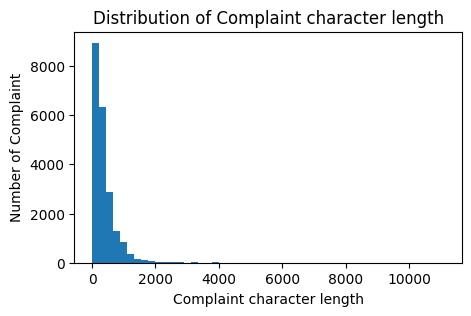

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(5,3))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show();

#### Find the top 40 words by frequency among all the articles after processing the text.

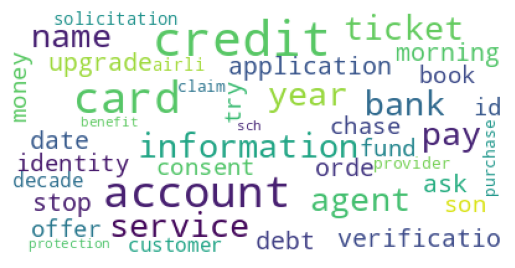

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [20]:
#Print the top 10 words in the unigram frequency
df2.head(10)

,unigram,count
0,account,46920
1,credit,31165
2,card,26785
3,xxxx,26351
4,payment,20911
5,bank,18457
6,time,16030
7,charge,15007
8,day,12976
9,money,11950


In [21]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [22]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,credit card,11327
1,credit report,3744
2,xxxx xxxx,3177
3,account account,2784
4,customer service,2641
5,bank account,2284
6,check account,2001
7,card account,1605
8,account credit,1577
9,debit card,1557


In [23]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the Complaint text"))
fig.show()

In [24]:
#Print the top 10 words in the trigram
df4.head(10)

,trigram,count
0,credit card account,1029
1,credit card company,901
2,xxxx xxxx xxxx,594
3,credit card credit,551
4,charge credit card,517
5,inquiry credit report,466
6,card credit card,455
7,account credit card,453
8,xx xx xx,331
9,credit reporting agency,323


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [25]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('XXXX','')

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [38]:
#All masked texts has been removed
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,4
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr...",application identity consent service credit id...,application identity consent service credit id...,1
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...,3
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...,3
78311,I have had flawless credit for yrs. I've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card XXXX problem balance tr...,credit yrs credit card problem balance transf...,2


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [29]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [30]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out
nmf_model = NMF(n_components=num_topics,random_state=40)



In [41]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6485

In [42]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'checking', 'business', 'transaction', 'number', 'branch', 'day', 'deposit', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['chase', 'balance', 'year', 'letter', 'application', 'debt', 'limit', 'information', 'company', 'score', 'account', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['error', 'year', 'account', 'credit', 'auto', 'mortgage', 'date', 'pay', 'day', 'time', 'statement', 'fee', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['day', 'company', 'refund', 'statement', 'time', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['state', 'information', 'sale', 'foreclosure', 'house', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'home', 'mortgage', 'loan']




In [43]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.round(2)
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [44]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [45]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,4
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr...",application identity consent service credit id...,application identity consent service credit id...,1
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [46]:
#Print the first 5 Complaint for each of the Topics
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice J.P. Morgan Chase restrict my ...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
24,mishandling of this account by Chase auto and ...,mishandle of this account by Chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
27,I opened an account with chase bank on XXXX an...,I open an account with chase bank on XXXX and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
35,I opened the saving account for the {$.} bonus...,I open the save account for the { $ . } bonus ...,save account bonus bonus auto transfer check t...,save account bonus bonus auto transfer check t...,0
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr...",application identity consent service credit id...,application identity consent service credit id...,1
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
15,Can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,I have a Chase credit card which is incorrectl...,I have a Chase credit card which be incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [47]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card", 2:"Others",3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr...",application identity consent service credit id...,application identity consent service credit id...,Credit card or prepaid card
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...,Theft/Dispute Reporting
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...,Theft/Dispute Reporting
78311,I have had flawless credit for yrs. I've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card XXXX problem balance tr...,credit yrs credit card problem balance transf...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [49]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Mortgage/Loan":4}

#Replace Topic Names with Topic
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,4
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,I upgrade my xxxx xxxx card in XX / XX/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"Chase Card was reported on XX/XX/. However, fr...","Chase Card be report on XX / XX/. however , fr...",application identity consent service credit id...,application identity consent service credit id...,1
11,"On XX/XX/, while trying to book a XXXX XXXX ...","on XX / xx/ , while try to book a XXXX xxxx ...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...,3
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...,3
78311,I have had flawless credit for yrs. I've had ...,I have have flawless credit for yrs . I 've ...,credit yrs credit card XXXX problem balance tr...,credit yrs credit card problem balance transf...,2


In [51]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [52]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,4
2,I upgraded my XXXX XXXX card in XX/XX/ and was...,1
10,"Chase Card was reported on XX/XX/. However, fr...",1
11,"On XX/XX/, while trying to book a XXXX XXXX ...",1
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
78310,I am not familiar with XXXX pay and did not un...,3
78311,I have had flawless credit for yrs. I've had ...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [53]:
import pickle

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**MODEL 1 - LOGISTIC REGRESSION**

In [57]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = LogisticRegression(random_state=0,max_iter = 500).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))



In [58]:
#LOAD MODELS
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("logreg_model.pkl","rb"))

In [60]:
predicted = loaded_model.predict(X_test)
result_logreg = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]
for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Ban

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted, target_names=target_names))

[[1227   27    7   32   16]
 [  41 1147   10   68   16]
 [  22   20  500   18   27]
 [  65   50    6 1026   26]
 [  24   29    7   11  846]]
                             precision    recall  f1-score   support

      Bank Account services       0.89      0.94      0.91      1309
Credit card or prepaid card       0.90      0.89      0.90      1282
                     Others       0.94      0.85      0.90       587
    Theft/Dispute Reporting       0.89      0.87      0.88      1173
              Mortgage/Loan       0.91      0.92      0.92       917

                   accuracy                           0.90      5268
                  macro avg       0.91      0.90      0.90      5268
               weighted avg       0.90      0.90      0.90      5268



**MODEL 2 - DECISION TREE**

In [62]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("DT_model.pkl", "wb"))

In [63]:
loaded_model = pickle.load(open("DT_model.pkl","rb"))

In [64]:
predicted = loaded_model.predict(X_test)
result_dt = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]
for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  - 

In [65]:
confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
print(classification_report(y_test, predicted, target_names=target_names))

[[1064   53   36  115   41]
 [  65 1023   39  105   50]
 [  28   42  449   34   34]
 [ 132   92   35  856   58]
 [  54   39   45   40  739]]
                             precision    recall  f1-score   support

      Bank Account services       0.79      0.81      0.80      1309
Credit card or prepaid card       0.82      0.80      0.81      1282
                     Others       0.74      0.76      0.75       587
    Theft/Dispute Reporting       0.74      0.73      0.74      1173
              Mortgage/Loan       0.80      0.81      0.80       917

                   accuracy                           0.78      5268
                  macro avg       0.78      0.78      0.78      5268
               weighted avg       0.78      0.78      0.78      5268



**MODEL 3 - RANDOM FOREST**

In [66]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

In [67]:
loaded_model = pickle.load(open("RF_model.pkl","rb"))

In [68]:
predicted = loaded_model.predict(X_test)
result_rf = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]
for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Ban

In [69]:
confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
print(classification_report(y_test, predicted, target_names=target_names))

[[1207   76    0   18    8]
 [ 104 1089    0   87    2]
 [ 183  200   33   74   97]
 [ 210  142    0  814    7]
 [ 118  141    0   19  639]]
                             precision    recall  f1-score   support

      Bank Account services       0.66      0.92      0.77      1309
Credit card or prepaid card       0.66      0.85      0.74      1282
                     Others       1.00      0.06      0.11       587
    Theft/Dispute Reporting       0.80      0.69      0.75      1173
              Mortgage/Loan       0.85      0.70      0.77       917

                   accuracy                           0.72      5268
                  macro avg       0.80      0.64      0.63      5268
               weighted avg       0.76      0.72      0.68      5268



**MODEL 4 - NAIVE BAYES**

In [70]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [71]:
loaded_model = pickle.load(open("nb_model.pkl","rb"))

In [72]:
predicted = loaded_model.predict(X_test)
result_nb = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]
for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Streaming output truncated to the last 5000 lines.
Credit card or prepaid card  -  Bank Account services
Bank Account services  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Mortgage/Loan
Credit card or prepaid card  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Repo

In [73]:
confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
print(classification_report(y_test, predicted, target_names=target_names))

[[1208   59    1   32    9]
 [ 185  971    0  117    9]
 [ 207  193   10   94   83]
 [ 246   60    1  858    8]
 [ 145   94    0   16  662]]
                             precision    recall  f1-score   support

      Bank Account services       0.61      0.92      0.73      1309
Credit card or prepaid card       0.71      0.76      0.73      1282
                     Others       0.83      0.02      0.03       587
    Theft/Dispute Reporting       0.77      0.73      0.75      1173
              Mortgage/Loan       0.86      0.72      0.78       917

                   accuracy                           0.70      5268
                  macro avg       0.75      0.63      0.61      5268
               weighted avg       0.74      0.70      0.67      5268



Comparing the evaluation metrics for all models, it is evident that **Log Reg model (Model 1)** has the best scores.

In [74]:
# Trying the best model on a custom text
loaded_model = pickle.load(open("logreg_model.pkl","rb"))
docs_new = "I can not get from chase who services my mortgage, who owns it and who has original loan docs"
docs_new = [docs_new]

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Mortgage/Loan
